<a href="https://colab.research.google.com/github/rajanchalotra23/TextUtils/blob/main/aies_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [46]:
df_client=pd.read_csv("../content/client_train.csv")     #client whether fraud or not fraud
df_invoice=pd.read_csv("../content/invoice_train.csv")   #consumption info

<ipython-input-46-b06a212f775f>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoice=pd.read_csv("../content/invoice_train.csv")   #consumption info


In [47]:
#%% Data preprocessing

# 1. dropping columns
df_client.head()
#df_client.drop(['disrict','client_catg','creation_date'], axis='columns',inplace=True)
df_client.drop(['creation_date','region'], axis='columns',inplace=True)
df_invoice.drop(['invoice_date','tarif_type','counter_number','counter_statue','counter_code','reading_remarque','counter_coefficient','consommation_level_2','consommation_level_3','consommation_level_4','old_index','new_index','months_number','counter_type'], axis='columns',inplace=True)

# 2. filling NaNs with average of that
grouped=df_invoice.groupby('client_id')

df_invoice['consommation_level_1'] = grouped['consommation_level_1'].transform(lambda x: x.fillna(x.mean()))


In [48]:
#%%
# 3. Treatment of outliers
lower_outliers=grouped.quantile(0.05)
upper_outliers=grouped.quantile(0.95)

###SKIPPED




In [49]:
df_mean=df_invoice.groupby('client_id').agg({'consommation_level_1':'mean'})
df_median=df_invoice.groupby('client_id').agg({'consommation_level_1':'median'})
df_std_dev=pd.DataFrame(df_invoice.groupby('client_id')["consommation_level_1"].std())
#df_kurtosis=df_invoice.groupby('client_id')["consommation_level_1"].apply(pd.DataFrame.kurt)

def compute_kurtosis(group):
    return group.kurt()

# Apply the custom function within each group
df_kurtosis = df_invoice.groupby('client_id')["consommation_level_1"].apply(compute_kurtosis)


In [50]:
df_new1=pd.merge(df_mean,df_median,"inner",on=['client_id'])
df_new2=pd.merge(df_std_dev,df_kurtosis,on=['client_id'])
df_new3=pd.merge(df_new1,df_new2,'inner',on=['client_id'])
df_final=pd.merge(df_new3,df_client,on=['client_id'])


df_final.rename(columns = {'consommation_level_1_x_x':'mean','consommation_level_1_y_x':'median','consommation_level_1_x_y':'std_dev','consommation_level_1_y_y':'kurt'}, inplace = True)
df_final.dropna(inplace=True)

df_final.groupby('target').count()

#%% Categorical variable treatment
df_final['disrict']=df_final['disrict'].astype('object')
df_final['client_catg']=df_final['client_catg'].astype('object')
#df_final['region']=df_final['region'].astype('object')
df_final['target']=df_final['target'].astype('object')
df_final.groupby('target')['client_id'].count()




target
0.0    69876
1.0     4673
Name: client_id, dtype: int64

In [51]:
#%%split the data into testing and training
df_final.drop('client_id',axis=1, inplace=True)
X=df_final.columns[0:6]
X
encoded_df_final=pd.get_dummies(df_final[X],drop_first=True)
list(encoded_df_final.columns)

import statsmodels.api as sm

df_finalY=df_final.target
df_finalX=sm.add_constant(encoded_df_final)


from sklearn.model_selection import train_test_split
df_finalX_train, df_finalX_test, df_finalY_train, df_finalY_test=train_test_split(df_finalX, df_finalY, test_size=0.25, random_state=6432)


<ipython-input-51-f1b2d48afc43>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  encoded_df_final=pd.get_dummies(df_final[X],drop_first=True)
<ipython-input-51-f1b2d48afc43>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  encoded_df_final=pd.get_dummies(df_final[X],drop_first=True)


In [52]:
#%% ENSEMBLING

# from imblearn.over_sampling import SMOTE

# df_final_smote = SMOTE()
# df_finalX_train, df_finalY_train = df_final_smote.fit_resample(df_finalX_train, df_finalY_train)


from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Bagging Classifier

df_finalY_train = pd.Categorical(df_finalY_train).codes

df_final_bagging=BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=500, random_state=42)
df_final_bagging.fit(df_finalX_train, df_finalY_train)



<ipython-input-52-b8e35e9847ab>:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_finalY_train = pd.Categorical(df_finalY_train).codes
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  random_state=42)

In [53]:
# %% TRAINING
#%% MODEL PERFORMANCE TRAINING

from sklearn.tree import DecisionTreeClassifier

# df_final_tree=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)

# df_final_tree.fit(df_finalX_train,df_finalY_train)



df_finalY_predict=df_final_bagging.predict(df_finalX_train)




Accuracy: 0.9998211443186493
AUC-ROC:  0.9985528219971056


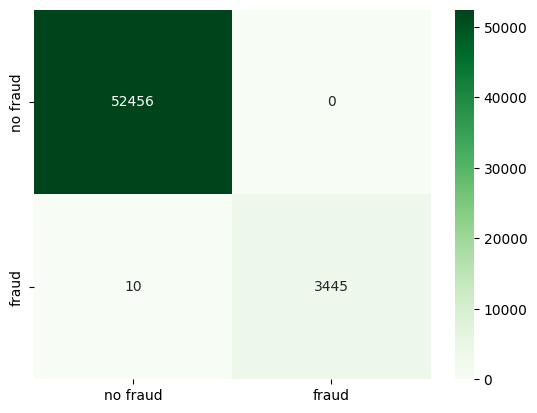

In [54]:
#%% Performance
from sklearn.metrics import confusion_matrix
import seaborn as sn
class_name=['no fraud','fraud']
confusionmatrix=confusion_matrix(df_finalY_train,df_finalY_predict)
sn.heatmap(confusionmatrix, annot=True, yticklabels=class_name, xticklabels=class_name, fmt='g', cmap="Greens")

#accuracy

from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(df_finalY_train,df_finalY_predict))
print('AUC-ROC: ',metrics.roc_auc_score(df_finalY_train, df_finalY_predict))

In [55]:
# %% TESTING
#%% MODEL PERFORMANCE TESTING

from sklearn.tree import DecisionTreeClassifier

# df_final_tree=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)

# df_final_tree.fit(df_finalX_train,df_finalY_train)

df_finalY_predict=df_final_bagging.predict(df_finalX_test)

Accuracy: 0.9340594484386737
AUC-ROC:  0.5019751092962622


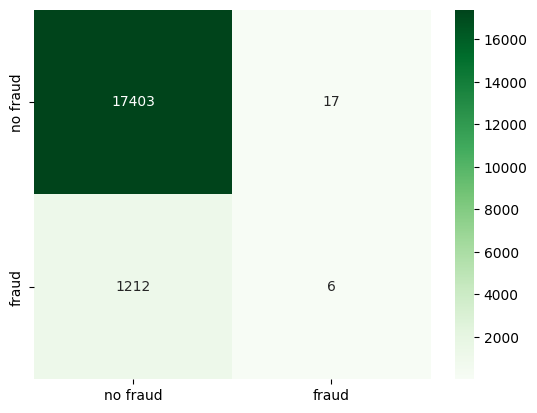

In [56]:
#%% Performance
from sklearn.metrics import confusion_matrix
import seaborn as sn
df_finalY_test = df_finalY_test.astype('int8')
array_finalY_test = df_finalY_test.values
df_finalY_test
class_name=['no fraud','fraud']
confusionmatrix=confusion_matrix(df_finalY_test,df_finalY_predict)
sn.heatmap(confusionmatrix, annot=True, yticklabels=class_name, xticklabels=class_name, fmt='g', cmap="Greens")

#accuracy

from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(df_finalY_test,df_finalY_predict))
print('AUC-ROC: ',metrics.roc_auc_score(df_finalY_test, df_finalY_predict))

**BOOSTING TECHNIQUE**

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

df_final_boosting=GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,random_state=0)
df_final_boosting.fit(df_finalX_train, df_finalY_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=0)

In [58]:
from sklearn.tree import DecisionTreeClassifier

# df_final_tree=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)

# df_final_tree.fit(df_finalX_train,df_finalY_train)

df_finalY_predict=df_final_boosting.predict(df_finalX_test)

Accuracy: 0.9291769503165576
AUC-ROC:  0.5016540073410892


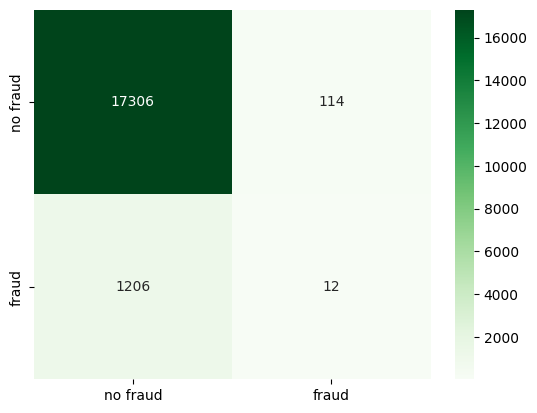

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
df_finalY_test = df_finalY_test.astype('int8')
array_finalY_test = df_finalY_test.values
df_finalY_test
class_name=['no fraud','fraud']
confusionmatrix=confusion_matrix(df_finalY_test,df_finalY_predict)
sn.heatmap(confusionmatrix, annot=True, yticklabels=class_name, xticklabels=class_name, fmt='g', cmap="Greens")

#accuracy

from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(df_finalY_test,df_finalY_predict))
print('AUC-ROC: ',metrics.roc_auc_score(df_finalY_test, df_finalY_predict))

**SMOTE**

In [60]:
! pip install imblearn

In [62]:
from imblearn.over_sampling import SMOTE
df_final_smote=SMOTE()
df_finalX_train, df_finalY_train=df_final_smote.fit_resample(df_finalX_train, df_finalY_train)

#importing packages
from sklearn.tree import DecisionTreeClassifier

df_final_tree=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
df_final_tree.fit(df_finalX_train,df_finalY_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

In [65]:
from sklearn.tree import DecisionTreeClassifier

# df_final_tree=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)

# df_final_tree.fit(df_finalX_train,df_finalY_train)

df_finalY_predict=df_final_tree.predict(df_finalX_test)

Accuracy: 0.7227170297242194
AUC-ROC:  0.45993139644709385


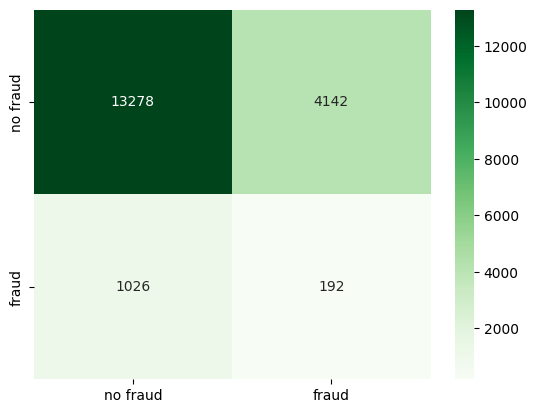

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
df_finalY_test = df_finalY_test.astype('int8')
array_finalY_test = df_finalY_test.values
df_finalY_test
class_name=['no fraud','fraud']
confusionmatrix=confusion_matrix(df_finalY_test,df_finalY_predict)
sn.heatmap(confusionmatrix, annot=True, yticklabels=class_name, xticklabels=class_name, fmt='g', cmap="Greens")

#accuracy

from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(df_finalY_test,df_finalY_predict))
print('AUC-ROC: ',metrics.roc_auc_score(df_finalY_test, df_finalY_predict))